# Esercitazione lab6

# <font color='yellow'> Problema di Classificazione: </font>

Confrontare i diversi metodi (non parametrico e con kernel), misurando `accuracy` e il tempo di esecuzione ed effettuando un *fine tuning* con Cross-Validation:

1. K-Neighbors Classifier (**KNC**) accoppiato con la Neighboorhood Component Analysis (**NCA**) per il miglior embedding dello spazio;
2. Support Vector Classifier (**SVC**);
3. Gaussian Process (**GP**).

## Caricamento del database [cancro]

In [10]:
import numpy as np
from sklearn import datasets

# caricamento dataset
b_cancer = datasets.load_breast_cancer()
X = b_cancer.data 
y = b_cancer.target 

In [11]:
print(f"Esempi del database {X.shape[0]}")
print(f"Features: {X.shape[1]}")

Esempi del database 569
Features: 30


In [12]:
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

Class distribution: {0: 212, 1: 357}


## Nested CV da utilizzare [classificazione]

In [13]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

def nested_cv(model, param_grid, X, y, outer_splits=5,
              inner_splits=5, scoring=['accuracy'], random_state=42, verbose=True):

    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    score_results = {metric: [] for metric in scoring}

    best_param_overall = None
    best_score = -np.inf 

    for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        if verbose:
            print(f"\nPerforming Outer Fold {outer_fold}/{outer_splits}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        if verbose:
            print("Performing GridSearchCV...")

        grid_search = GridSearchCV(model, param_grid, cv=inner_cv,
                                   n_jobs=-1, scoring=scoring[0])
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        if verbose:
            print(f" Best Params: {best_params}")

        y_pred = best_model.predict(X_test)

        if 'accuracy' in scoring:
            acc = accuracy_score(y_test, y_pred)
            score_results['accuracy'].append(acc)

            if acc > best_score:
                best_score = acc
                best_param_overall = best_params

            if verbose:
                print(f" Accuracy: {acc:.4f}")

    result = {}
    for metric, scores in score_results.items():
        result[f"Nested CV {metric.upper()}"] = f"{np.mean(scores):.4f} ± {np.std(scores):.4f}"

    result["Best Parameters with highest accuracy"] = best_param_overall

    return result

## NCA Neighborhood component analysis + k-NC KNeighborsClassifier

NCA per ridurre lo spazio utilizzando un pipeline

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nca', NeighborhoodComponentsAnalysis(random_state=42, tol = 1e-5)),
    ('knn', KNeighborsClassifier())
])

# Parametri per NCA e kNC insieme
nca_knn_params = {
    "nca__n_components": [1, 2, 3] ,           
    #"nca__init": ['identity', 'random'],         
    #"nca__max_iter": [50, 100],
    
    "knn__n_neighbors": [1, 3, 5],
    "knn__weights": ['uniform', 'distance'],
    "knn__algorithm": ['ball_tree', 'kd_tree']
}

In [16]:
import time

start_time = time.time()

knn_results = nested_cv(pipeline, nca_knn_params, X, y,
                        outer_splits=5, inner_splits=5,
                        scoring=['accuracy'])

end_time = time.time()

print(f'knn Results: \n{knn_results}')
print(f'Tempo di esecuzione {end_time - start_time}')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'nca__n_components': 3}
 Accuracy: 0.9474

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'nca__n_components': 2}
 Accuracy: 0.9825

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'nca__n_components': 3}
 Accuracy: 0.9474

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'nca__n_components': 3}
 Accuracy: 0.9649

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'nca__n_components': 1}
 Accuracy: 0.9646
knn Results: 
{'Nested CV ACCURACY': '0.

## SVC Support Vector Classification

In [17]:
from sklearn.svm import SVC

svm_model = SVC()

svm_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

start_time = time.time()
svm_results = nested_cv(svm_model, svm_params, X_std, y, 
                          outer_splits = 5, inner_splits = 5)

end_time = time.time()

print(f'SVM Results: \n {svm_results}')
print(f'Tempo di esecuzione {end_time - start_time}')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
 Accuracy: 0.9737

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
 Accuracy: 0.9825

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
 Accuracy: 0.9649

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
 Accuracy: 0.9825

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
 Accuracy: 0.9735
SVM Results: 
 {'Nested CV ACCURACY': '0.9754 ± 0.0066', 'Best Parameters with highest accuracy': {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}}
Tempo di esecuzione 0.4067840576171875


## Processi Gaussiani 

In [35]:
from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

gpc_model = GaussianProcessClassifier()

gpc_params = {
    "warm_start": [True, False]
}

start_time = time.time()

gpc_results = nested_cv(gpc_model, gpc_params, X_std, y, 
                          outer_splits = 5, inner_splits = 5, 
                          scoring = ['accuracy'])

end_time = time.time()

print(f'GPC Results: \n {gpc_results}')
print(f'Tempo di esecuzione {end_time - start_time}')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'warm_start': True}
 Accuracy: 0.9474

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'warm_start': True}
 Accuracy: 0.9825

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'warm_start': True}
 Accuracy: 0.9649

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'warm_start': True}
 Accuracy: 0.9561

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'warm_start': True}
 Accuracy: 0.9469
GPC Results: 
 {'Nested CV ACCURACY': '0.9596 ± 0.0132', 'Best Parameters with highest accuracy': {'warm_start': True}}
Tempo di esecuzione 1.81687593460083


# <font color='yellow'> Problema di regressione </font>

Confrontare i diversi metodi (non parametrico e con kernel), misurando `r2`score e il tempo di esecuzione ed effettuando un *fine tuning* con Cross-Validation:

1. K-Neighbors Regressor (**KNR**);
2. Radius Neighbors Regressor (**RNR**);
3. Support Vector Regressor (**SVR**).

## Caricamento del dataset [case California]

In [36]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

X_regr = housing.data
y_regr = housing.target

print(housing.data.shape, housing.target.shape)

(20640, 8) (20640,)


In [37]:
print(f"Esempi del database {X_regr.shape[0]}")
print(f"Features: {X_regr.shape[1]}")

Esempi del database 20640
Features: 8


In [38]:
np.unique(y)

array([0, 1])

### Subset sampling

In [47]:
display(X_regr.shape, y_regr.shape) 

(20640, 8)

(20640,)

In [48]:
subset_size = 5000  

indices = np.random.permutation(X_regr.shape[0])[:subset_size]

In [49]:
X_subset = X_regr[indices]
y_subset = y_regr[indices]

print(X_subset.shape, y_subset.shape)  # Subset size

(5000, 8) (5000,)


In [50]:
scaler = StandardScaler()
X_sstd = scaler.fit_transform(X_subset)

## Scaling

In [39]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_regr)

## Nested CV  [regressione]

In [40]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def nested_cv_regression(model, param_grid, X, y, outer_splits=5,
                         inner_splits=5, scoring=None, random_state=42, verbose=True):
    if scoring is None:
        scoring = ['r2']  # Default metric

    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    score_results = {metric: [] for metric in scoring}

    best_param_overall = None
    best_r2_score = -np.inf 

    for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        if verbose:
            print(f"\nPerforming Outer Fold {outer_fold}/{outer_splits}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        if verbose:
            print("Performing GridSearchCV...")

        grid_search = GridSearchCV(model, param_grid, cv=inner_cv,
                                   n_jobs=-1, scoring=scoring[0])
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        if verbose:
            print(f" Best Params: {best_params}")

        y_pred = best_model.predict(X_test)

        if 'r2' in scoring:
            r2 = r2_score(y_test, y_pred)
            score_results['r2'].append(r2)
            if r2 > best_r2_score:
                best_r2_score = r2
                best_param_overall = best_params
            if verbose:
                print(f" R²: {r2:.4f}")

        if 'mae' in scoring:
            mae = mean_absolute_error(y_test, y_pred)
            score_results['mae'].append(mae)
            if verbose:
                print(f" MAE: {mae:.4f}")

        if 'rmse' in scoring:
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            score_results['rmse'].append(rmse)
            if verbose:
                print(f" RMSE: {rmse:.4f}")

    result = {}
    for metric, scores in score_results.items():
        result[f"Nested CV {metric.upper()}"] = f"{np.mean(scores):.4f} ± {np.std(scores):.4f}"

    result["Best Parameters with highest R2 score"] = best_param_overall

    return result

## KNeighborsRegressor 

In [41]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import time

knr_model = KNeighborsRegressor()

knr_params = {
    'n_neighbors': [1, 3, 5],                
    #'weights': ['uniform', 'distance'],             
    #'algorithm': ['ball_tree', 'kd_tree', 'brute'],  
    #'leaf_size': [20, 30, 40],                      
    'metric': ['minkowski', 'euclidean', 'manhattan'],  
}

start_time = time.time()

knr_results = nested_cv_regression(knr_model, knr_params, X_std, y_regr, 
                        outer_splits=5, inner_splits=5, 
                        scoring=['r2'])

end_time = time.time()

print(f'KNeighborsRegressor Results: \n{knr_results}')
print(f'Tempo di esecuzione: {end_time - start_time} secondi')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'metric': 'manhattan', 'n_neighbors': 5}
 R²: 0.7063

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'metric': 'manhattan', 'n_neighbors': 5}
 R²: 0.7255

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'metric': 'manhattan', 'n_neighbors': 5}
 R²: 0.7275

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'metric': 'manhattan', 'n_neighbors': 5}
 R²: 0.7369

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'metric': 'manhattan', 'n_neighbors': 5}
 R²: 0.7227
KNeighborsRegressor Results: 
{'Nested CV R2': '0.7238 ± 0.0099', 'Best Parameters with highest R2 score': {'metric': 'manhattan', 'n_neighbors': 5}}
Tempo di esecuzione: 15.202718019485474 secondi


## RadiusNeighborsRegressor (raw)

## SVR

In [52]:
from sklearn.svm import SVR

svr_model = SVR()

svr_params = {
    'C': [0.1, 1, 10],                     # Regolarizzazione
    #'kernel': ['linear', 'poly', 'rbf']  
    # 'degree': [2, 3, 4],                   # Grado di polinomio
    # 'gamma': ['scale', 'auto'],            
    #'epsilon': [0.1, 0.2, 0.5]             
}

start_time = time.time()

svr_results = nested_cv_regression(svr_model, svr_params, X_sstd, y_subset, 
                                     outer_splits=5, inner_splits=5, 
                                     scoring=['r2'])

end_time = time.time()

print(f'SVR Results: \n{svr_results}')
print(f'Tempo di esecuzione: {end_time - start_time} secondi')


Performing Outer Fold 1/5
Performing GridSearchCV...
 Best Params: {'C': 10}
 R²: 0.7430

Performing Outer Fold 2/5
Performing GridSearchCV...
 Best Params: {'C': 10}
 R²: 0.7581

Performing Outer Fold 3/5
Performing GridSearchCV...
 Best Params: {'C': 10}
 R²: 0.7711

Performing Outer Fold 4/5
Performing GridSearchCV...
 Best Params: {'C': 10}
 R²: 0.7344

Performing Outer Fold 5/5
Performing GridSearchCV...
 Best Params: {'C': 10}
 R²: 0.7743
SVR Results: 
{'Nested CV R2': '0.7562 ± 0.0155', 'Best Parameters with highest R2 score': {'C': 10}}
Tempo di esecuzione: 25.2790048122406 secondi


# Stima di densita' KDE

- stima della densità mediante kernel: KernelDensity applicato a un dataset noto 

## Info per il dataset di Housing California

In [53]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

X = california_housing.data
y = california_housing.target

print("Features of the dataset:")
print(X.head())

Features of the dataset:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


In [54]:
print("\nDescription",california_housing.DESCR)


Description .. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using o

## Stima KDE

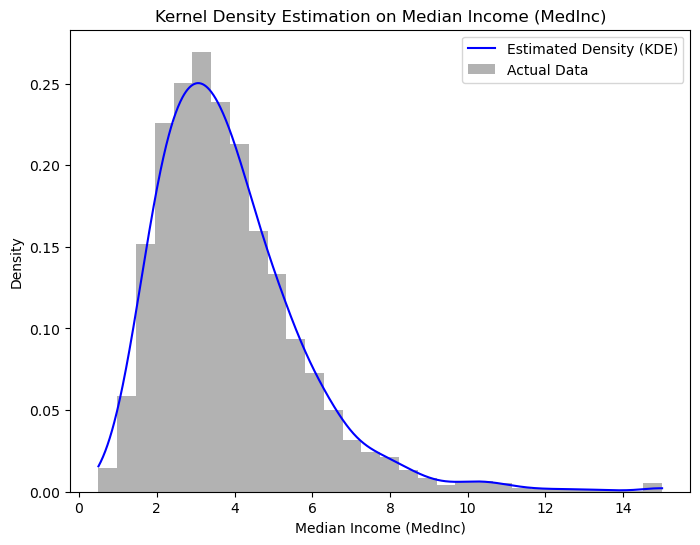

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

data = X['MedInc'].values[:, np.newaxis]  

kde = KernelDensity(kernel='gaussian', bandwidth=0.5)

kde.fit(data)

x_plot = np.linspace(data.min(), data.max(), 1000)[:, np.newaxis]
log_dens = kde.score_samples(x_plot)

plt.figure(figsize=(8, 6))
plt.plot(x_plot[:, 0], np.exp(log_dens), label='Estimated Density (KDE)', color='blue')
plt.hist(data[:, 0], bins=30, density=True, alpha=0.6, color='gray', label='Actual Data')
plt.title('Kernel Density Estimation on Median Income (MedInc)')
plt.xlabel('Median Income (MedInc)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Outlier/Novelty detection

- Confrontare One-Class SVM con Local Outlier Factor (LOF)

In [56]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor 

one_class_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
y_pred_svm = one_class_svm.fit_predict(X_std)

In [57]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = lof.fit_predict(X_std)

In [58]:
results_df = pd.DataFrame({
    'One-Class SVM': y_pred_svm,
    'Local Outlier Factor': y_pred_lof
})

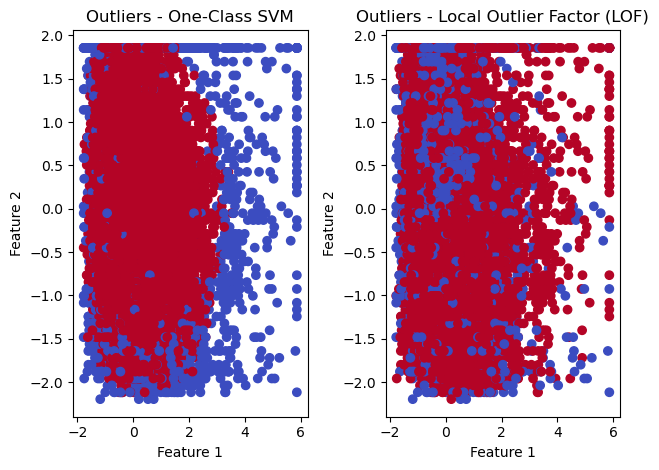

In [59]:
# Visualizzazione degli outliers con One-Class SVM
plt.subplot(1, 2, 1)
plt.scatter(X_std[:, 0], X_std[:, 1], c=y_pred_svm, cmap='coolwarm', marker='o')
plt.title("Outliers - One-Class SVM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Visualizzazione degli outliers con Local Outlier Factor
plt.subplot(1, 2, 2)
plt.scatter(X_std[:, 0], X_std[:, 1], c=y_pred_lof, cmap='coolwarm', marker='o')
plt.title("Outliers - Local Outlier Factor (LOF)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()